# Motor Imagery Deep Learning project <br>
By: James McIntyre and John McLinden

In [198]:
# imports
import os
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, losses
import mne 
mne.utils.set_config('MNE_USE_CUDA', 'true')  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.test.gpu_device_name())

/device:GPU:0


## Load data
Load saved epochs and labels from preprocessing step

In [199]:
filepath = os.getcwd()

data = np.load(filepath + '\\RecordedProjectData\\preprocessedOnlineDataset_EpochsAndLabels.npz')
x_train = data['training_epochs']
y_train = data['training_labels']
x_test = data['testing_epochs']
y_test = data['testing_labels']

Create one-hot encoding for labels

In [200]:
# Usign their one-hot encoding function
def to_one_hot(y, by_sub=False):
    if by_sub:
        new_array = np.array(["nan" for nan in range(len(y))])
        for index, label in enumerate(y):
            new_array[index] = ''.join([i for i in label if not i.isdigit()])
    else:
        new_array = y.copy()
    total_labels = np.unique(new_array)
    mapping = {}
    for x in range(len(total_labels)):
        mapping[total_labels[x]] = x
    for x in range(len(new_array)):
        new_array[x] = mapping[new_array[x]]

    return tf.keras.utils.to_categorical(new_array)
        
#Transform y to one-hot-encoding
# enc = onehot
y_test_valid_OH = to_one_hot(y_test)
y_train_OH = to_one_hot(y_train)

Reshape data then apply MinMax scaling, in the same way that the CNN was trained

In [201]:
# Reshape for scaling
x_train_reshapedForScaling = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_valid_reshapedForScaling = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [202]:
# Scale train and test separately
x_train_scaled = minmax_scale(x_train_reshapedForScaling, axis=2)
x_test_valid_scaled = minmax_scale(x_test_valid_reshapedForScaling, axis=2)

In [203]:
# Reshape after scaling, reshape training data after SMOTE
x_test_valid_reshaped = x_test_valid_scaled.reshape(x_test_valid_scaled.shape[0], int(x_test_valid_scaled.shape[1]/2),2).astype(np.float64)

Create Val/Test split from test dataset

In [204]:
#Create Validation/test
x_valid_reshaped, x_test_reshaped, y_valid_OH, y_test_OH = train_test_split(x_test_valid_reshaped,
                                                    y_test_valid_OH,
                                                    stratify=y_test_valid_OH,
                                                    test_size=0.50,
                                                    random_state=42)

Apply SMOTE for data augmentation<br>
Only apply to training set <br>
Does not apply for online dataset, only for the limited recorded dataset.


In [205]:
# # smote
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_train_smote, y_train_OH_smote = sm.fit_resample(x_train_scaled, y_train_OH)
# print('classes count')
# print ('before oversampling = {}'.format(y_train_OH.sum(axis=0)))
# print ('after oversampling = {}'.format(y_train_OH_smote.sum(axis=0)))

# no smote
x_train_smote, y_train_OH_smote = x_train_scaled, y_train_OH

Reshape training data after SMOTE

In [206]:
x_train_reshaped = x_train_smote.reshape(x_train_smote.shape[0], int(x_train_smote.shape[1]/2),2).astype(np.float64)

## Train CNN architecture on new dataset

Set up and train a CNN

In [207]:
class HopefullNet(tf.keras.Model):
    """
    Original HopeFullNet
    """
    def __init__(self, inp_shape = (640,2)):
        super(HopefullNet, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tf.keras.layers.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(296, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense2 = tf.keras.layers.Dense(148, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense3 = tf.keras.layers.Dense(74, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(self.drop_rate)
        self.out = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, input_tensor):
        conv1 = self.conv1(input_tensor)
        batch_n_1 = self.batch_n_1(conv1)
        conv2 = self.conv2(batch_n_1)
        batch_n_2 = self.batch_n_2(conv2)
        spatial_drop_1 = self.spatial_drop_1(batch_n_2)
        conv3 = self.conv3(spatial_drop_1)
        avg_pool1 = self.avg_pool1(conv3)
        conv4 = self.conv4(avg_pool1)
        spatial_drop_2 = self.spatial_drop_2(conv4)
        flat = self.flat(spatial_drop_2)
        dense1 = self.dense1(flat)
        dropout1 = self.dropout1(dense1)
        dense2 = self.dense2(dropout1)
        dropout2 = self.dropout2(dense2)
        return self.out(dropout2)

Compile model

In [208]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = HopefullNet()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Where to save model
modelPath = filepath + r'\models\OnlineDatasetTraainedModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=6, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

In [209]:
hist = model.fit(x_train_reshaped, y_train_OH_smote, epochs=100, batch_size=10,
                validation_data=(x_valid_reshaped, y_valid_OH), callbacks=callbacksList)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 1.7575 - accuracy: 0.2793
Epoch 1: val_loss improved from inf to 1.38595, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\OnlineDatasetTraainedModel.h5
78/78 [==============================] - 6s 52ms/step - loss: 1.7575 - accuracy: 0.2793 - val_loss: 1.3860 - val_accuracy: 0.2624
Epoch 2/100
77/78 [============================>.] - ETA: 0s - loss: 1.5578 - accuracy: 0.2558
Epoch 2: val_loss did not improve from 1.38595
78/78 [==============================] - 4s 49ms/step - loss: 1.5556 - accuracy: 0.2548 - val_loss: 1.3862 - val_accuracy: 0.2525
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 1.4928 - accuracy: 0.2613
Epoch 3: val_loss did not improve from 1.38595
78/78 [==============================] - 3s 45ms/step - loss: 1.4928 - accuracy: 0.2613 - val_loss: 1.3866 - val_accuracy: 0.2437
Epoch 4/100
77/78 [============================>.] - ETA: 0s - loss: 1.4525 - accur

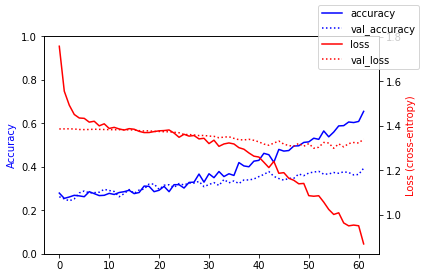

In [210]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])

## CNN autoencoder

Set up the CNN autoencoder <br>
set up decoder with transpose convolutional layers

Create an autoencoder for feature learning

In [211]:
latent_dim = 296

class MyEncoder(tf.keras.Model):
    """
    Based on Original HopeFullNet
    """
    def __init__(self, inp_shape = (640,2)):
        super(MyEncoder, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tfp.bijectors.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tfp.bijectors.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.flat = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(296, activation='relu')

    def call(self, input_tensor):
        conv1 = self.conv1(input_tensor)
        batch_n_1 = self.batch_n_1(conv1)
        conv2 = self.conv2(batch_n_1)
        batch_n_2 = self.batch_n_2(conv2)
        spatial_drop_1 = self.spatial_drop_1(batch_n_2)
        conv3 = self.conv3(spatial_drop_1)
        avg_pool1 = self.avg_pool1(conv3)
        conv4 = self.conv4(avg_pool1)
        spatial_drop_2 = self.spatial_drop_2(conv4)
        flat = self.flat(spatial_drop_2)
        return self.out(flat)

class MyDecoder(tf.keras.Model):
    """
    Based on Original HopeFullNet
    """
    def __init__(self, inp_shape = (296,)):
        super(MyDecoder, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tfp.bijectors.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tfp.bijectors.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.reshape1 = tf.keras.layers.Reshape((148,2))
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(296, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense2 = tf.keras.layers.Dense(148, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.out = tf.keras.layers.Dense(1280, activation='relu')
        self.reshape2 = tf.keras.layers.Reshape((640,2))

    def call(self, input_tensor):
        dense1 = self.dense1(input_tensor)
        flat = self.reshape1(dense1)
        spatial_drop_2 = self.spatial_drop_2(flat)
        conv4 = self.conv4(spatial_drop_2)
        avg_pool1 = self.avg_pool1(conv4)
        conv3 = self.conv3(avg_pool1)
        spatial_drop_1 = self.spatial_drop_1(conv3)
        batch_n_2 = self.batch_n_2(spatial_drop_1)
        conv2 = self.conv2(batch_n_2)
        batch_n_1 = self.batch_n_1(conv2)
        conv1 = self.conv1(batch_n_1)
        flat1 = self.flat(conv1)
        last = self.out(flat1)
        return self.reshape2(last)


class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = MyEncoder()
    self.decoder = MyDecoder()

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Compile the autoencoder

In [212]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

modelPath = filepath+'\\models\\autoencoderOnlineDataModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=10, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

Train the autoencoder

In [213]:
hist = autoencoder.fit(x_train_reshaped, x_train_reshaped,
                epochs=400, batch_size=10,
                shuffle=True,
                validation_data=(x_valid_reshaped, x_valid_reshaped),
                callbacks = callbacksList)

Epoch 1/400
77/78 [============================>.] - ETA: 0s - loss: 0.0890
Epoch 1: val_loss improved from inf to 0.04451, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel.h5
78/78 [==============================] - 10s 79ms/step - loss: 0.0886 - val_loss: 0.0445
Epoch 2/400
78/78 [==============================] - ETA: 0s - loss: 0.0446
Epoch 2: val_loss did not improve from 0.04451
78/78 [==============================] - 6s 73ms/step - loss: 0.0446 - val_loss: 0.0456
Epoch 3/400
78/78 [==============================] - ETA: 0s - loss: 0.0450
Epoch 3: val_loss did not improve from 0.04451
78/78 [==============================] - 6s 75ms/step - loss: 0.0450 - val_loss: 0.0450
Epoch 4/400
77/78 [============================>.] - ETA: 0s - loss: 0.0448
Epoch 4: val_loss did not improve from 0.04451
78/78 [==============================] - 5s 68ms/step - loss: 0.0449 - val_loss: 0.0451
Epoch 5/400
77/78 [============================>.] - E

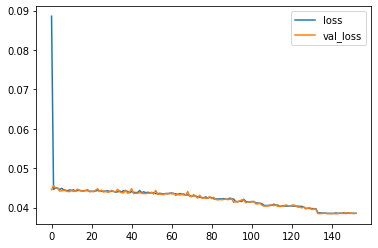

In [214]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [215]:

autoencoder.save(filepath+'\\models\\autoencoderOnlineDataModel')


INFO:tensorflow:Assets written to: c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel\assets


INFO:tensorflow:Assets written to: c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel\assets


In [216]:
autoencoder.summary()

Model: "autoencoder_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_encoder_10 (MyEncoder)   multiple                  2904744   
                                                                 
 my_decoder_10 (MyDecoder)   multiple                  4233064   
                                                                 
Total params: 7,137,808
Trainable params: 7,137,552
Non-trainable params: 256
_________________________________________________________________


## append an MLP to the trained encoder

(Brain Surgery) <br>

Clip off the encoder part of the neural network<br>
Freeze the lower convoluutional layers<br>

Connect to another couple of fully connected layers<br>
Only train those last few layers

In [217]:
autoencoder_loaded = tf.keras.models.load_model(filepath+'\\models\\autoencoderOnlineDataModel')

Freeze encoder and add an MLP to the output of the encoder in another network

In [218]:
NewNet = tf.keras.Sequential()
for layer in autoencoder.encoder.layers[:-1]:
    layer.trainable = False
    NewNet.add(layer)
drop_rate = 0.5
NewNet.add(tf.keras.layers.Dense(296, activation='relu'))
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(148, activation='relu'))
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(74, activation='relu'))
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(4, activation='softmax'))

# check trainablitity

for layer in NewNet.layers:
    print(layer)
    print(layer.trainable)

NewNet.summary()


False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 640, 32)           1312      
                                                                 
 conv1d_69 (Conv1D)          (None, 621, 32)           20512     
                                                                 
 spatial_dropout1d_54 (Spati  (None, 621, 32)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_70 (Conv1D)          (None, 616, 32)           6176      
                                                                 
 average_pooling1d_27 (Avera  (None, 308, 32)          0         
 gePooling1D)                                                    
                                     

In [219]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

NewNet.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Where to save model
modelPath = filepath + r'\models\autoencoderMlpModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=6, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

In [220]:
hist = NewNet.fit(x_test_reshaped, y_test_OH, epochs=100, batch_size=10,
                    validation_data=(x_valid_reshaped, y_valid_OH), callbacks=callbacksList)

Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 1.3854 - accuracy: 0.2489
Epoch 1: val_loss improved from inf to 1.38630, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderMlpModel.h5
91/91 [==============================] - 6s 41ms/step - loss: 1.3854 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2492
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 1.3877 - accuracy: 0.2589
Epoch 2: val_loss did not improve from 1.38630
91/91 [==============================] - 4s 40ms/step - loss: 1.3878 - accuracy: 0.2588 - val_loss: 1.3863 - val_accuracy: 0.2492
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 1.3858 - accuracy: 0.2478
Epoch 3: val_loss did not improve from 1.38630
91/91 [==============================] - 4s 49ms/step - loss: 1.3858 - accuracy: 0.2478 - val_loss: 1.3863 - val_accuracy: 0.2492
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 1.3874 - accuracy: 0.

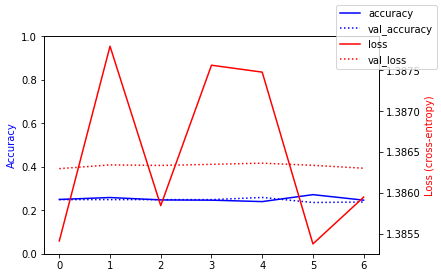

In [221]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])

## Transfer learning

In [222]:
trainedModel_loaded = tf.keras.models.load_model(filepath + '\\models\\roi_b')

Replace the output layer for 4 rather than 5 classes

In [223]:
trainedModel_newLayers = tf.keras.Sequential()
for layer in trainedModel_loaded.layers[:10]: # go through until flatten layer
    trainedModel_newLayers.add(layer)

trainedModel_newLayers.add(tf.keras.layers.Dense(296, activation='relu'))
trainedModel_newLayers.add(tf.keras.layers.Dropout(0.5))
trainedModel_newLayers.add(tf.keras.layers.Dense(148, activation='relu'))
trainedModel_newLayers.add(tf.keras.layers.Dropout(0.5))
trainedModel_newLayers.add(tf.keras.layers.Dense(74, activation='relu'))
trainedModel_newLayers.add(tf.keras.layers.Dropout(0.5))
trainedModel_newLayers.add(tf.keras.layers.Dense(4, activation='softmax'))

trainedModel_newLayers.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 640, 32)           1312      
                                                                 
 batch_normalization (BatchN  (None, 640, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 621, 32)           20512     
                                                                 
 batch_normalization_1 (Batc  (None, 621, 32)          128       
 hNormalization)                                                 
                                                                 
 spatial_dropout1d (SpatialD  (None, 621, 32)          0         
 ropout1D)                                                       
                                                     

Freeze the first few convolutional layers

In [224]:
for i in range(10):
    trainedModel_newLayers.layers[i].trainable = False

for layer in trainedModel_newLayers.layers:
    print(layer)
    print('Trainable? ' + str(layer.trainable))

trainedModel_newLayers.summary()

Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 640, 32)           1312      
                                                                 
 batch_normalization (BatchN  (None, 640, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 621, 32)           20512     
                                                                 
 batch_normalization_1 (Batc  (None, 621, 32)          128       
 hNormalization)                   

In [225]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
modelPath = os.path.join(os.getcwd(), 'tunedMode.h5')
print('Saving to: ' + modelPath)

trainedModel_newLayers.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq="epoch"  # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=4, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

hist = trainedModel_newLayers.fit(x_train_reshaped, y_train_OH_smote, epochs=100, batch_size=10,
                validation_data=(x_test_reshaped, y_test_OH), callbacks=callbacksList) #32

Saving to: c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
Epoch 1/100
77/78 [============================>.] - ETA: 0s - loss: 1.4105 - accuracy: 0.2558
Epoch 1: val_loss improved from inf to 1.38740, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
78/78 [==============================] - 7s 56ms/step - loss: 1.4109 - accuracy: 0.2548 - val_loss: 1.3874 - val_accuracy: 0.2588
Epoch 2/100
76/78 [============================>.] - ETA: 0s - loss: 1.3908 - accuracy: 0.2711
Epoch 2: val_loss improved from 1.38740 to 1.38642, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
78/78 [==============================] - 4s 45ms/step - loss: 1.3919 - accuracy: 0.2703 - val_loss: 1.3864 - val_accuracy: 0.2731
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.2844
Epoch 3: val_loss improved from 1.38642 to 1.38529, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
78/7

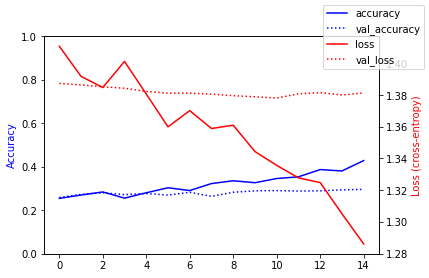

In [226]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])


Evaluate final model

29/29 [==============================] - 1s 20ms/step - loss: 1.3709 - accuracy: 0.3120

Accuracy: 0.31201764941215515

Loss:  1.3709309101104736
29/29 [==============================] - 1s 16ms/step

 Cohen kappa 

 0.08258944853376216

 Classification report 

               precision    recall  f1-score   support

       Right       0.29      0.32      0.30       227
        Left       0.36      0.25      0.30       226
        Rest       0.29      0.22      0.25       227
      tongue       0.32      0.45      0.38       227

    accuracy                           0.31       907
   macro avg       0.31      0.31      0.31       907
weighted avg       0.31      0.31      0.31       907


 Confusion matrix 

 [[ 72  34  55  66]
 [ 55  57  35  79]
 [ 71  31  51  74]
 [ 51  37  36 103]]


<AxesSubplot:>

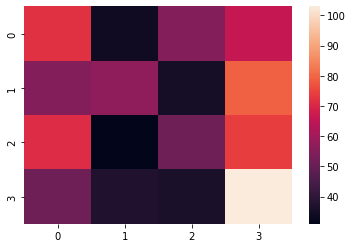

In [227]:
testLoss, testAcc = trainedModel_newLayers.evaluate(x_valid_reshaped, y_valid_OH)
print('\nAccuracy:', testAcc)
print('\nLoss: ', testLoss)

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
yPred = trainedModel_newLayers.predict(x_valid_reshaped)

# convert from one hot encode in string
yTestClass = np.argmax(y_valid_OH, axis=1)
yPredClass = np.argmax(yPred,axis=1)

print('\n Cohen kappa \n\n',
  cohen_kappa_score(
      yTestClass,
      yPredClass
      )
  )

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=["Right", "Left", "Rest", "tongue"]
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )

import seaborn as sns
sns.heatmap(confusion_matrix(
      yTestClass,
      yPredClass,
      ))